In [21]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [22]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.orm import declarative_base, relationship, sessionmaker
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey

In [24]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect = True)

C:\Users\svetl\AppData\Local\Temp\ipykernel_4492\3646528746.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  base.prepare(engine, reflect = True)


In [25]:
# View all of the classes that automap found
for class_station in base.classes.keys():
    print(class_station)

station
measurement


In [26]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

#for class_station in base.classes.keys():
    #table_references[class_station] = base.classes[class_station]

In [27]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [28]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()

print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


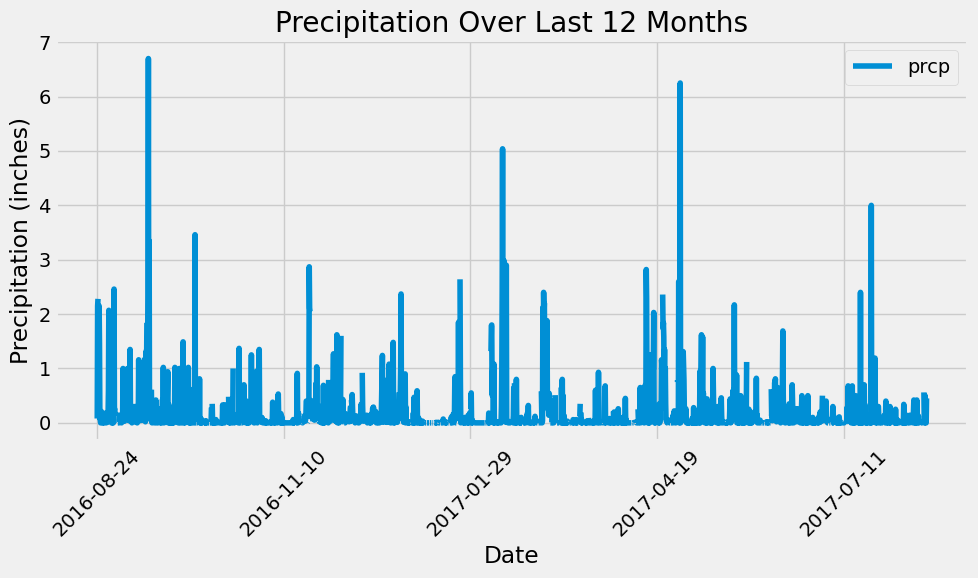

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
from datetime import datetime, timedelta

most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = (
    session.query(measurement.date, measurement.prcp)
    .filter(measurement.date >= one_year_ago)
    .order_by(measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["date", "prcp"])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by="date")

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x="date", y="prcp", figsize=(10, 6), title="Precipitation Over Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [30]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df["prcp"].describe()
print("Summary Statistics for Precipitation Data:")
print(precipitation_summary)

Summary Statistics for Precipitation Data:
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [35]:
# Design a query to calculate the total number of stations in the dataset

total_stations = session.query(func.count(station.station)).scalar()

print(f"The total number of stations in the dataset is: {total_stations}")


The total number of stations in the dataset is: 9


In [37]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = (
    session.query(measurement.station, func.count(measurement.station))
    .group_by(measurement.station)
    .order_by(func.count(measurement.station).desc())
    .all()
)

# Display the results

print(most_active_stations)
# print("Most Active Stations (Station ID and Observation Count):")
# for station, count in most_active_stations:
  #  print(f"Station: {station}, Observations: {count}")

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [40]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0][0]  # Assuming the previous query ran and results are stored in most_active_stations
temperature_stats = (
    session.query(
        func.min(measurement.tobs),
        func.max(measurement.tobs),
        func.avg(measurement.tobs)
    )
    .filter(measurement.station == most_active_station)
    .all()
)

lowest_temp, highest_temp, average_temp = temperature_stats[0]

print(f"Temperature Statistics for Station {most_active_station}:")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {average_temp:.2f}")

Temperature Statistics for Station USC00519281:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


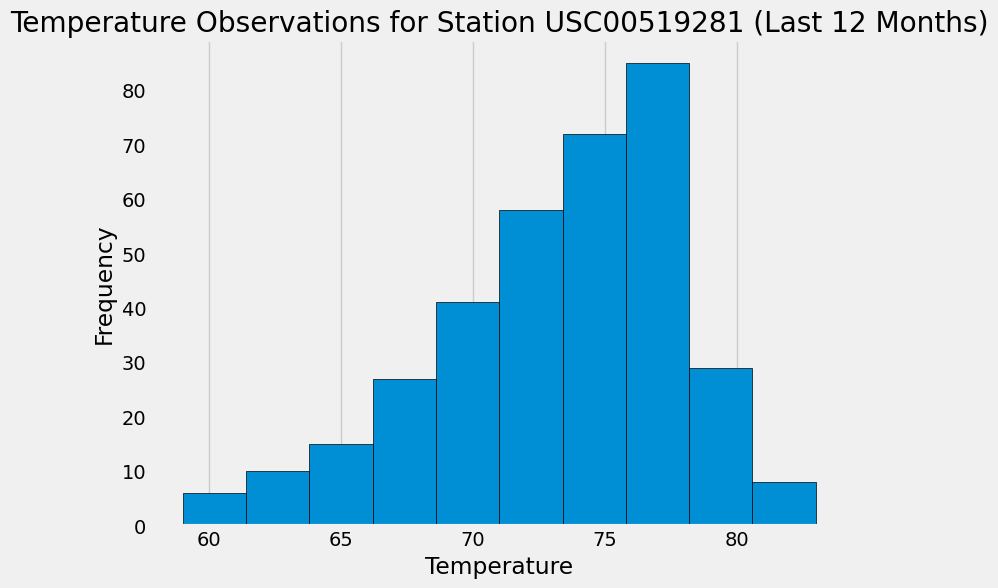

In [42]:
# Using the most active station id
one_year_ago = most_recent_date - timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temperature_data = (
    session.query(measurement.tobs)
    .filter(measurement.station == most_active_station)
    .filter(measurement.date >= one_year_ago)
    .all()
)

# Convert the query results to a list of temperatures
temperature_list = [temp[0] for temp in temperature_data]

# Plot the data as a histogram
plt.figure(figsize=(8, 6))
hist = plt.hist(temperature_list, bins=10, edgecolor="black")
plt.title(f"Temperature Observations for Station {most_active_station} (Last 12 Months)")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.grid(axis="y")

plt.show()


# Close Session

In [43]:
# Close Session
session.close()

In [46]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect("hawaii.sqlite")

# Inspect the table names
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(tables)

conn.close()

[]


In [47]:
from flask import Flask, jsonify
from sqlalchemy import create_engine, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import datetime as dt

# Setup the database
engine = create_engine("sqlite:///hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)

# References to tables
measurement = Base.classes.measurement
station = Base.classes.station

# Start Flask application
app = Flask(__name__)

# Homepage route
@app.route("/")
def home():
    return (
        f"Welcome to the Climate API!<br/><br/>"
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/&lt;start&gt;<br/>"
        f"/api/v1.0/&lt;start&gt;/&lt;end&gt;"
    )

# Precipitation route
@app.route("/api/v1.0/precipitation")
def precipitation():
    session = Session(engine)
    # Find the most recent date
    most_recent_date = session.query(func.max(measurement.date)).scalar()
    most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
    one_year_ago = most_recent_date - dt.timedelta(days=365)
    
    # Query precipitation data
    results = (
        session.query(measurement.date, measurement.prcp)
        .filter(measurement.date >= one_year_ago)
        .all()
    )
    session.close()
    
    # Convert to dictionary
    precipitation_data = {date: prcp for date, prcp in results}
    return jsonify(precipitation_data)

# Stations route
@app.route("/api/v1.0/stations")
def stations():
    session = Session(engine)
    # Query all stations
    results = session.query(station.station).all()
    session.close()
    
    # Convert to list
    stations_list = [station[0] for station in results]
    return jsonify(stations_list)

# Temperature observations route
@app.route("/api/v1.0/tobs")
def tobs():
    session = Session(engine)
    # Find the most active station
    most_active_station = (
        session.query(measurement.station)
        .group_by(measurement.station)
        .order_by(func.count(measurement.station).desc())
        .first()[0]
    )
    # Find the most recent date
    most_recent_date = session.query(func.max(measurement.date)).scalar()
    most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
    one_year_ago = most_recent_date - dt.timedelta(days=365)
    
    # Query temperature observations
    results = (
        session.query(measurement.tobs)
        .filter(measurement.station == most_active_station)
        .filter(measurement.date >= one_year_ago)
        .all()
    )
    session.close()
    
    # Convert to list
    temps_list = [temp[0] for temp in results]
    return jsonify(temps_list)

# Start and Start-End routes
@app.route("/api/v1.0/<start>")
@app.route("/api/v1.0/<start>/<end>")
def stats(start, end=None):
    session = Session(engine)
    # Convert start and end to datetime objects
    start_date = dt.datetime.strptime(start, "%Y-%m-%d")
    end_date = dt.datetime.strptime(end, "%Y-%m-%d") if end else None
    
    # Build query
    if end_date:
        results = session.query(
            func.min(measurement.tobs),
            func.avg(measurement.tobs),
            func.max(measurement.tobs),
        ).filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()
    else:
        results = session.query(
            func.min(measurement.tobs),
            func.avg(measurement.tobs),
            func.max(measurement.tobs),
        ).filter(measurement.date >= start_date).all()
    
    session.close()
    
    # Extract results
    stats_list = list(results[0])
    return jsonify({
        "TMIN": stats_list[0],
        "TAVG": stats_list[1],
        "TMAX": stats_list[2]
    })

# Run the app
if __name__ == "__main__":
    app.run(debug=True)

C:\Users\svetl\AppData\Local\Temp\ipykernel_4492\1840455255.py:10: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


AttributeError: measurement